In [1]:
# gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,622005,33.3,1353361,72.3,1119819,59.9
Vcells,1152414,8.8,8388608,64.0,1801877,13.8


In [ ]:
# library(tidyverse)

In [ ]:
# library(caret)

Loading required package: lattice



Dataset from kaggle: https://www.kaggle.com/datasets/steve1215rogg/student-lifestyle-dataset

The dataset contains continuous features representing a students' lifestyle with their academic performance as the label. The features include study hours per day, extracurricular hours, sleep hours, social hours, physical activity hours, and stress level. Stress level however, is a categorical variable that will require transformation to integer values. The label, GPA, is continuous and on a 4.0 scale. The goal of this analysis is to model GPA as a response, then Stress Level as a response, to the features and interpret the contributions of each feature. 

I hope to model the factors that go into predicting GPA and stress level of students. GPA is a continuous variable, so I will use regression techniques, whereas stress level is a continuous variable so I will use GLMs and GAMs. 

To model GPA, I will start by using multiple linear regression and see if there is anything I don't expect. Then, I will conduct a hypothesis test to ensure that at least one feature contributes to the response. Next I will look at the feature selection to determine what features belong with every sized model and measure the AIC, BIC, and adj R^2 for each model. For each sized model selected, I will conduct an ANOVA test to determine whether the reduced model is sufficient or not. With the final model, I will look at the predictions and how they compare to the real GPA values. Overall, I will have a model that can fairly accurately predict GPA based on features in the dataset. 

To model stress levels, I'll need to reorganize the dataframe so that the stress level category is a binary variable. I'll start by running a GLM with all the predictors and pulling out the significant predictors. Then, I will run another GLM on only the significant predictors and run an ANOVA test to determine whether the reduced model is sufficient. In case there are any nonlinear relationships that haven't been recognized, I will run a GAM on the significant predictors I found using the GLM. I will use the smoothing parameter on these predictors and evaluate the EDFs and plot.gams to determine whether there are nonlinear relationships or not. Overall, I will find the best model to predict stress level from features in the dataset. 

In [1]:
df = read.csv('student_lifestyle_dataset.csv')
head(df)

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
2,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
3,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
4,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
5,5,8.1,0.6,6.5,2.2,6.6,3.51,High
6,6,6.0,2.1,8.0,0.3,7.6,2.85,Moderate


In [2]:
dim(df)

[1] 2000    8

In [3]:
df = subset(df, select=-1)

In [4]:
unique(df$Stress_Level)

[1] "Moderate" "Low"      "High"

In [5]:
library(dplyr)

df$Stress_Level = recode(df$Stress_Level, 'Low'=0, 'Moderate'=1, 'High'=2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
head(df)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6.9,3.8,8.7,2.8,1.8,2.99,1
2,5.3,3.5,8.0,4.2,3.0,2.75,0
3,5.1,3.9,9.2,1.2,4.6,2.67,0
4,6.5,2.1,7.2,1.7,6.5,2.88,1
5,8.1,0.6,6.5,2.2,6.6,3.51,2
6,6.0,2.1,8.0,0.3,7.6,2.85,1


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

corrplot 0.95 loaded



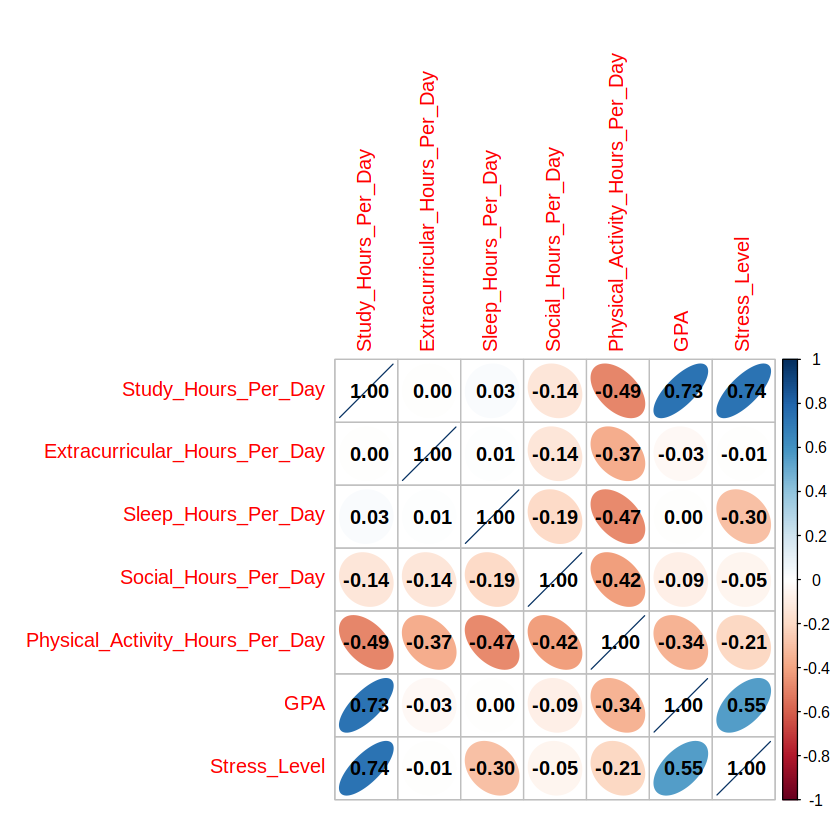

In [7]:
install.packages("corrplot")
library(corrplot)

corrplot(cor(df), method='ellipse', addCoef.col='black')
# correlation plot for some eda to visualize any trends before writing the models 

Stronger positive correlations between Stress_Level and Study_Hours_Per_Day, GPA and Study_Hours_Per_Day

Medium positive correlations between Stress_Level and GPA

Stronger negative correlations between Physical_Activity_Hours_Per_Day and Study_Hours_Per_Day, Physical_Activity_Hours_Per_Day and Sleep_Hours_Per_Day

In [8]:
summary(df)

 Study_Hours_Per_Day Extracurricular_Hours_Per_Day Sleep_Hours_Per_Day
 Min.   : 5.000      Min.   :0.00                  Min.   : 5.000     
 1st Qu.: 6.300      1st Qu.:1.00                  1st Qu.: 6.200     
 Median : 7.400      Median :2.00                  Median : 7.500     
 Mean   : 7.476      Mean   :1.99                  Mean   : 7.501     
 3rd Qu.: 8.700      3rd Qu.:3.00                  3rd Qu.: 8.800     
 Max.   :10.000      Max.   :4.00                  Max.   :10.000     
 Social_Hours_Per_Day Physical_Activity_Hours_Per_Day      GPA       
 Min.   :0.000        Min.   : 0.000                  Min.   :2.240  
 1st Qu.:1.200        1st Qu.: 2.400                  1st Qu.:2.900  
 Median :2.600        Median : 4.100                  Median :3.110  
 Mean   :2.705        Mean   : 4.328                  Mean   :3.116  
 3rd Qu.:4.100        3rd Qu.: 6.100                  3rd Qu.:3.330  
 Max.   :6.000        Max.   :13.000                  Max.   :4.000  
  Stress_Leve

In [9]:
df$Stress_Level = factor(df$Stress_Level)
str(df)

'data.frame':	2000 obs. of  7 variables:
 $ Study_Hours_Per_Day            : num  6.9 5.3 5.1 6.5 8.1 6 8 8.4 5.2 7.7 ...
 $ Extracurricular_Hours_Per_Day  : num  3.8 3.5 3.9 2.1 0.6 2.1 0.7 1.8 3.6 0.7 ...
 $ Sleep_Hours_Per_Day            : num  8.7 8 9.2 7.2 6.5 8 5.3 5.6 6.3 9.8 ...
 $ Social_Hours_Per_Day           : num  2.8 4.2 1.2 1.7 2.2 0.3 5.7 3 4 4.5 ...
 $ Physical_Activity_Hours_Per_Day: num  1.8 3 4.6 6.5 6.6 7.6 4.3 5.2 4.9 1.3 ...
 $ GPA                            : num  2.99 2.75 2.67 2.88 3.51 2.85 3.08 3.2 2.82 2.76 ...
 $ Stress_Level                   : Factor w/ 3 levels "0","1","2": 2 1 1 2 3 2 3 3 1 2 ...


# Multiple Linear Regression

The goal of multiple regression is to find the best line that goes through the data, $ Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + . . . \beta_p X_p + \epsilon $. Where $X$ is the predictors/features, $Y$ is the dependent variable/response, $\epsilon$ represents the random deviation due to natural processes, $\alpha$ is the basline average when all the features are zero, and $\beta$ is the true regression line. The algorithm estimates the parameters $\alpha$ and $\beta$ using a least squares approach. 

In [10]:
full_model = lm(GPA ~ ., data=df)
summary(full_model)


Call:
lm(formula = GPA ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59944 -0.13439 -0.00251  0.13369  0.77543 

Coefficients: (1 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      2.013849   0.038062  52.910   <2e-16 ***
Study_Hours_Per_Day              0.154016   0.005128  30.033   <2e-16 ***
Extracurricular_Hours_Per_Day   -0.007418   0.003959  -1.874   0.0611 .  
Sleep_Hours_Per_Day             -0.003658   0.003609  -1.014   0.3109    
Social_Hours_Per_Day             0.001427   0.002789   0.512   0.6088    
Physical_Activity_Hours_Per_Day        NA         NA      NA       NA    
Stress_Level1                   -0.022392   0.016125  -1.389   0.1651    
Stress_Level2                   -0.006591   0.021317  -0.309   0.7572    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2025 on 1993 degrees of freedom
Multipl

Perfect collinearity in physical activity variable, removing the feature and re-running the model

In [11]:
df = subset(df, select=-5)
head(df)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,GPA,Stress_Level
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6.9,3.8,8.7,2.8,2.99,1
2,5.3,3.5,8.0,4.2,2.75,0
3,5.1,3.9,9.2,1.2,2.67,0
4,6.5,2.1,7.2,1.7,2.88,1
5,8.1,0.6,6.5,2.2,3.51,2
6,6.0,2.1,8.0,0.3,2.85,1


In [12]:
set.seed(11111)
n = floor(0.8 * nrow(df)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df)), size = n) #randomly sample indicies to be included in the training set

train = df[index, ] #set the training set to be the randomly sampled rows of the dataframe
test = df[-index, ] #set the testing set to be the remaining rows
cat("There are", dim(train)[1], "rows and",dim(train)[2],"columns in the training set. ")  #check the dimensions
cat("There are", dim(test)[1], "rows and",dim(test)[2],"columns in the testing set.")  #check the dimensions

There are 1600 rows and 6 columns in the training set. There are 400 rows and 6 columns in the testing set.

In [13]:
new_model = lm(GPA ~ ., data=train)
summary(new_model)


Call:
lm(formula = GPA ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60002 -0.13325 -0.00645  0.13550  0.78308 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    2.026052   0.043184  46.917   <2e-16 ***
Study_Hours_Per_Day            0.151621   0.005821  26.047   <2e-16 ***
Extracurricular_Hours_Per_Day -0.004368   0.004463  -0.979    0.328    
Sleep_Hours_Per_Day           -0.004686   0.004090  -1.146    0.252    
Social_Hours_Per_Day           0.001642   0.003146   0.522    0.602    
Stress_Level1                 -0.020982   0.018092  -1.160    0.246    
Stress_Level2                  0.001585   0.023919   0.066    0.947    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.205 on 1593 degrees of freedom
Multiple R-squared:  0.5317,	Adjusted R-squared:  0.5299 
F-statistic: 301.4 on 6 and 1593 DF,  p-value: < 2.2e-16


Interpretation: The summary output means that holding all other features constant, an increase in one unit of Study_Hours_Per_Day, GPA increases by 0.15 points. The intercept, 2.03, represents the GPA when all predictors are equal to zero.

In [14]:
# looking for any more evidence of collinearity
source('vif_function.r')
vif(new_model)

,GVIF,Df,GVIF^(1/(2*Df))
Study_Hours_Per_Day,2.594124,1,1.610628
Extracurricular_Hours_Per_Day,1.024928,1,1.012387
Sleep_Hours_Per_Day,1.342513,1,1.158669
Social_Hours_Per_Day,1.080796,1,1.039614
Stress_Level,2.880648,2,1.302784


Initially, fitting a model on the full dataframe yielded perfect collinearity in the physical activity feature, so I dropped it, re-ran the model, and ran the vif function to ensure there was no more evidence of collinearity. Since none of the vif values are above 5, the features appear to be independent of one another

## Hypothesis Test:

$H_{0}$: None of the variables are related to the response variable

$H_{1}$: At least one of the variables are related to the response variable

In [15]:
null_test = lm(GPA ~ 1, data=train)

anova(null_test, new_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1599,143.01153,NA,NA,NA,NA
2,1593,66.97602,6,76.03551,301.4128,3.523161e-258


The p-value is very close to zero indicating a strong rejection of the null hypothesis. From this, I can conclude that at least one of the features is related to the response

## Feature Selection

Using regsubsets() will print out the features corresponding to each sized model. It iterates from one feature to the amount of features specified and it returns the model, and corresponding features, with the lowest sum of squarred errors. 

In [16]:
install.packages("leaps")
library(leaps)

best_features = regsubsets(GPA ~ ., data = train, nvmax = 6)
summary(best_features)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Subset selection object
Call: regsubsets.formula(GPA ~ ., data = train, nvmax = 6)
6 Variables  (and intercept)
                              Forced in Forced out
Study_Hours_Per_Day               FALSE      FALSE
Extracurricular_Hours_Per_Day     FALSE      FALSE
Sleep_Hours_Per_Day               FALSE      FALSE
Social_Hours_Per_Day              FALSE      FALSE
Stress_Level1                     FALSE      FALSE
Stress_Level2                     FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         Study_Hours_Per_Day Extracurricular_Hours_Per_Day Sleep_Hours_Per_Day
1  ( 1 ) "*"                 " "                           " "                
2  ( 1 ) "*"                 " "                           " "                
3  ( 1 ) "*"                 " "                           "*"                
4  ( 1 ) "*"                 "*"                           "*"                
5  ( 1 ) "*"                 "*"                           "*"           

## Model Selection

From the previous output, I'm measuring the AIC, BIC, and adj R^2 for each sized model. AIC is best for prediction, and to find the best sized model, the AIC should be minimized. The BIC is best for explanation and the best model will also have the lowest value. The adj R^2 measures how well the predicted model fits to the actual values, and the best model (with respect to adj R^2) will have the highest value. 

In [17]:
models = list(
    lm(GPA ~ Study_Hours_Per_Day, data=train), 
    lm(GPA ~ Study_Hours_Per_Day + Stress_Level, data=train), 
    lm(GPA ~ Study_Hours_Per_Day + Stress_Level + Sleep_Hours_Per_Day, data=train), 
    lm(GPA ~ Study_Hours_Per_Day + Stress_Level + Sleep_Hours_Per_Day + Extracurricular_Hours_Per_Day, data=train), 
    lm(GPA ~ Study_Hours_Per_Day + Stress_Level + Sleep_Hours_Per_Day + Extracurricular_Hours_Per_Day + Social_Hours_Per_Day, 
       data=train))

df1 = data.frame('AIC' = numeric(), 'BIC' = numeric(), 'Adjusted R^2' = numeric())

for (model in models){
    aic = AIC(model)
    bic = BIC(model)
    adjr = summary(model)$adj.r.squared
    
    df1 = rbind(df1, data.frame('AIC' = aic, 'BIC' = bic, 'Adjusted R^2' = adjr))
}

df1$NumberParams = c(1, 2, 3, 4, 5)
df1 = df1 %>% select(NumberParams, everything())
df1

NumberParams,AIC,BIC,Adjusted.R.2
<dbl>,<dbl>,<dbl>,<dbl>
1,-522.1212,-505.9879,0.5288099
2,-523.8646,-496.9758,0.5299099
3,-523.4497,-491.1831,0.5300809
4,-522.6018,-484.9575,0.5301246
5,-520.8755,-477.8535,0.5299100


AIC chooses model 2

BIC chooses model 1 

Adj R^2 chooses model 4

However, all the adj r^2 values are very close together, within 0.01, so most likely, the model with only one feature will be sufficient. To confirm this, I will run F-tests between all reduced models and the full model, then the reduced models against one another. 

In [18]:
# aic_model = lm(GPA ~ Study_Hours_Per_Day + Stress_Level, data=train)
# bic_model = lm(GPA ~ Study_Hours_Per_Day, data=train)
# adjr2_model = lm(GPA ~ Study_Hours_Per_Day + Stress_Level + Sleep_Hours_Per_Day + Extracurricular_Hours_Per_Day, data=train)

## F-test

This test determines whether the reduced model is sufficient or not for MLR. The ANOVA command checks whether the full model explains significantly more of the variance than the reduced model. 

In [19]:
aic_model = lm(GPA ~ Study_Hours_Per_Day + Stress_Level, data=train)
anova(aic_model, new_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1596,67.10218,NA,NA,NA,NA
2,1593,66.97602,3,0.1261589,1.000215,0.3918161


In [20]:
bic_model = lm(GPA ~ Study_Hours_Per_Day, data=train)
anova(bic_model, new_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1598,67.34348,NA,NA,NA,NA
2,1593,66.97602,5,0.3674605,1.747983,0.1205825


In [21]:
adjr2_model = lm(GPA ~ Study_Hours_Per_Day + Stress_Level + Sleep_Hours_Per_Day + Extracurricular_Hours_Per_Day, data=train)
anova(adjr2_model, new_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1594,66.98748,NA,NA,NA,NA
2,1593,66.97602,1,0.01145885,0.2725446,0.6017025


In [22]:
anova(bic_model, aic_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1598,67.34348,NA,NA,NA,NA
2,1596,67.10218,2,0.2413016,2.869633,0.05701243


In [23]:
# anova(bic_model, adjr2_model)

In [24]:
# anova(aic_model, adjr2_model)

For all the F-tests, the p values are larger than an accpeted alpha value (0.05), so we reject the null hypothesis indicating that the reduced model is sufficient. Because I tested the reduced models against the full model and the reduced models against each other, this means that the bic model with one predictor is sufficient to model the data. 

## Simple Linear Regression

The goal of simple regression is to find the best line that goes through the data, $ Y = \alpha + \beta X + \epsilon $. Where $X$ is the predictor/feature, $Y$ is the dependent variable/response, $\epsilon$ represents the random deviation due to natural processes, $\alpha$ is the expected value of the response when the predictor is zero, and $\beta$ is the slope, representing the change in the response for one unit increase in the predictor. The algorithm estimates the parameters $\alpha$ and $\beta$ using a least squares approach. 

In [38]:
bic_model = lm(GPA ~ Study_Hours_Per_Day, data=train)
summary(bic_model)


Call:
lm(formula = GPA ~ Study_Hours_Per_Day, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6055 -0.1362 -0.0022  0.1366  0.7998 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.967625   0.027439   71.71   <2e-16 ***
Study_Hours_Per_Day 0.153323   0.003618   42.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2053 on 1598 degrees of freedom
Multiple R-squared:  0.5291,	Adjusted R-squared:  0.5288 
F-statistic:  1796 on 1 and 1598 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


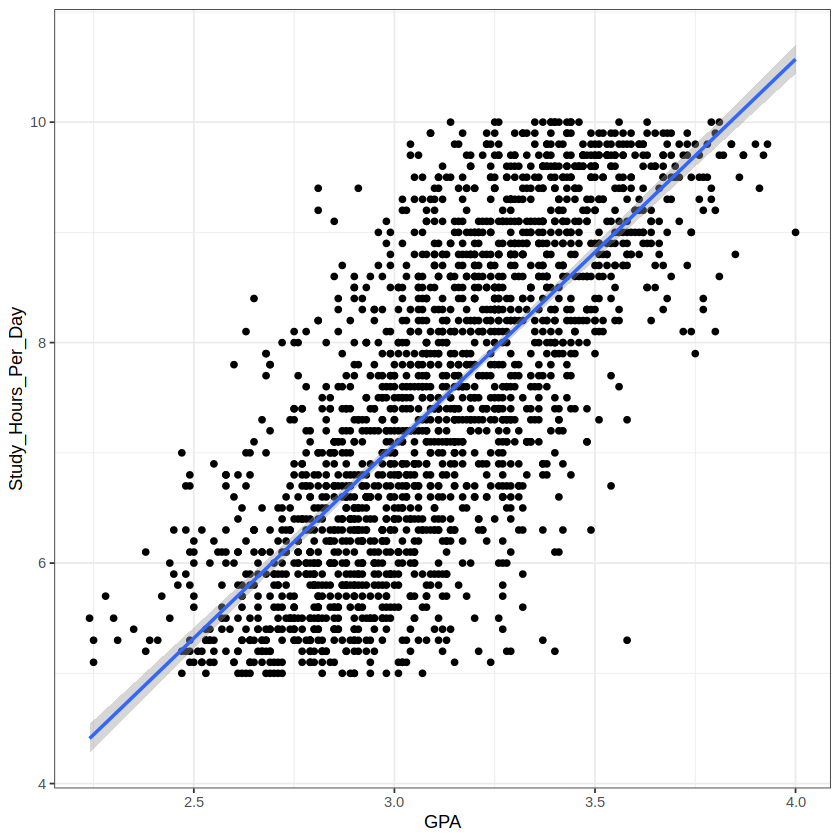

In [25]:
library(ggplot2)

ggplot(df, aes(x=GPA, y=Study_Hours_Per_Day))+
    geom_point()+
    geom_smooth(method='lm')+
    theme_bw()

High variance, large spread of data points about the regression line

### Predictions

In [26]:
predictions = bic_model %>% predict(test)
# predictions will return all the GPA predictions for the test set, I'm just printing out the first one 
print('The first vector of the test set is:')
test[1, ] # prints out the test vector for the first row 
cat("The predicted GPA for the first test vector is:", predictions[1]) # returns the prediction for the first test row 

[1] "The first vector of the test set is:"


,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,GPA,Stress_Level
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6.9,3.8,8.7,2.8,2.99,1


The predicted GPA for the first test vector is: 3.025556

The predicted GPA using the bic model (simple linear regression) is very close to the actual GPA indicating a good model fit. 

In [39]:
# creating a new test vector on the full model 
newdata = data.frame(Study_Hours_Per_Day=6, Extracurricular_Hours_Per_Day=2, Sleep_Hours_Per_Day=8, 
                    Social_Hours_Per_Day=2, Stress_Level=2)
newdata$Stress_Level = factor(newdata$Stress_Level)
# prediction of the new test vector from the full model
cat("\n The full model prediction of the new test vector is: ", predict(new_model, newdata, type='response'))
# creating a new test vector on the bic model
newdata1 = data.frame(Study_Hours_Per_Day=6)
# prediction of the new test vector from the bic model 
cat("\n The bic model (simple linear regression) prediction of the new test vector is:", predict(bic_model, newdata1))
# creating a new test vector on the aic model
newdata2 = data.frame(Study_Hours_Per_Day=6, Stress_Level=2)
newdata2$Stress_Level = factor(newdata2$Stress_Level)
# prediction of the new test vector from the aic model 
cat("\n The aic model prediction of the new test vector is:", predict(aic_model, newdata2))
# creating a new test vector on the adj r^2 model
newdata3 = data.frame(Study_Hours_Per_Day=6, Stress_Level=2, Sleep_Hours_Per_Day=8, Extracurricular_Hours_Per_Day=2)
newdata3$Stress_Level = factor(newdata3$Stress_Level)
# prediction of the new test vector from the adj r^2 model 
cat("\n The adj r^2 model prediction of the new test vector is:", predict(adjr2_model, newdata3))


 The full model prediction of the new test vector is:  2.894422
 The bic model (simple linear regression) prediction of the new test vector is: 2.887565
 The aic model prediction of the new test vector is: 2.906839
 The adj r^2 model prediction of the new test vector is: 2.895546

Naturally, the adjusted r^2 model will have the prediction closest to the full model because it retains the most features compared to the aic and bic models. However, all predictions are really similar and only differ by about 0.02, suggesting low variance between the predictive performance of each model. 

# Modifying the Dataframe with Stress as the Response

In [28]:
stress_df = df[df$Stress_Level %in% c(0, 2), ]
# limiting the dataframe to only binary variables to i'm modeling low stress and high stress 

In [29]:
stress_df$Stress_Level = ifelse(stress_df$Stress_Level == 2, 1, 0)
# transforming the high stress (2) to a binary variable so the models work better 
stress_df$Stress_Level = factor(stress_df$Stress_Level)
str(stress_df)

'data.frame':	1326 obs. of  6 variables:
 $ Study_Hours_Per_Day          : num  5.3 5.1 8.1 8 8.4 5.2 9.7 6.4 5 8.9 ...
 $ Extracurricular_Hours_Per_Day: num  3.5 3.9 0.6 0.7 1.8 3.6 3.6 2.2 3.3 0.3 ...
 $ Sleep_Hours_Per_Day          : num  8 9.2 6.5 5.3 5.6 6.3 8 5.7 8.5 6.8 ...
 $ Social_Hours_Per_Day         : num  4.2 1.2 2.2 5.7 3 4 2.5 4.8 4.4 0.7 ...
 $ GPA                          : num  2.75 2.67 3.51 3.08 3.2 2.82 3.43 2.82 2.87 3.4 ...
 $ Stress_Level                 : Factor w/ 2 levels "0","1": 1 1 2 2 2 1 2 2 1 2 ...


In [30]:
head(stress_df)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,GPA,Stress_Level
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,5.3,3.5,8.0,4.2,2.75,0
3,5.1,3.9,9.2,1.2,2.67,0
5,8.1,0.6,6.5,2.2,3.51,1
7,8.0,0.7,5.3,5.7,3.08,1
8,8.4,1.8,5.6,3.0,3.20,1
9,5.2,3.6,6.3,4.0,2.82,0


# GLM

Generalived Linear Models (GLMs) have three components: a random component, systematic component, and link function. The random component refers to the probability distribution of the response variable. In this case, the response follows a binomial distribution where 1 represents high stress and 0 represents low stress. The systematic component refers to the explanatory variables as a combination of linear predictors. The link function connects the two components and says how the expected value of the response relates to the linear predictor of explanatory variables. 

In [31]:
library(mgcv)

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-41. For overview type 'help("mgcv-package")'.



In [32]:
stress_glm = glm(Stress_Level ~ ., data=stress_df, family=binomial)
summary(stress_glm)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Stress_Level ~ ., family = binomial, data = stress_df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.54041   0.00000   0.00004   0.00272   2.70322  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -9.9009     3.4275  -2.889  0.00387 ** 
Study_Hours_Per_Day             7.9527     1.1430   6.958 3.46e-12 ***
Extracurricular_Hours_Per_Day  -0.3025     0.2317  -1.306  0.19160    
Sleep_Hours_Per_Day            -5.1432     0.7841  -6.560 5.39e-11 ***
Social_Hours_Per_Day            0.1269     0.1579   0.804  0.42163    
GPA                            -0.8912     1.4428  -0.618  0.53678    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1410.60  on 1325  degrees of freedom
Residual deviance:  100.43  on 1320  degrees of freedom
AIC: 112.43

Number of Fisher Scoring iterations: 

Interpretation: The summary output of a GLM represents the log odds, so holding all other features constant, a unit increase in Study_Hours_Per_Day increases the log odds of a positive response (1) by 7.9527. So the odds of a positive response would increase by a factor of 2843. This means that, with all other factors held constant, one unit increase in study hours per day, increases the odds of having a high stress level by a factor of 2843. The same interpretation can be done for Sleep_Hours_Per_Day, where a unit increase in sleep hours per day decreases the odds of experiencing high stress by a factor of $\frac{1}{\exp(-5.1432)} = 172$. 

In [33]:
# significant predictors of the full model are study hours and sleep hours 
stress_glm1 = glm(Stress_Level ~ Study_Hours_Per_Day + Sleep_Hours_Per_Day, data=stress_df, family=binomial)
summary(stress_glm1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Stress_Level ~ Study_Hours_Per_Day + Sleep_Hours_Per_Day, 
    family = binomial, data = stress_df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.37726   0.00000   0.00006   0.00336   2.48602  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -11.2923     1.8884  -5.980 2.23e-09 ***
Study_Hours_Per_Day   7.5681     1.0374   7.295 2.98e-13 ***
Sleep_Hours_Per_Day  -5.0155     0.7493  -6.693 2.18e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1410.60  on 1325  degrees of freedom
Residual deviance:  103.08  on 1323  degrees of freedom
AIC: 109.08

Number of Fisher Scoring iterations: 11


The coefficient interpretation is the same as the previous, full model. It's interesting to note that the AIC is lower, suggesting that the reduced model may actually predict the response better than the full model. 

## ANOVA test between full model and reduced model

This test determines whether there is a difference in deviance between the two GLM models using the chi-squared distribution.

In [34]:
anova(stress_glm1, stress_glm, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1323,103.0802,NA,NA,NA
2,1320,100.4259,3,2.654338,0.4480429


Large p value indicates that we fail to reject the null and conclude that the reduced model is sufficient. Therefore, to model Stress_Level, the predictors Study_Hours_Per_Day and Sleep_Hours_Per_Day are sufficient. 

# GAM

Generalized Additive Models (GAMs) is a semi-parametric regression model. In other words, it doesn't assume any underlying linear patterns in the data. Using one requires specification of a smoothing parameter. A smoothing spline is a piecewise function where each segment is a polynomial. This way, each spline is continuous and has a derivative. I'm using a GAM to determine is the data fits better with a smoothing parameter, and if successful, it will indicate that my data has nonlinear relationships. 

In [35]:
stress_gam1 = gam(Stress_Level ~ s(Study_Hours_Per_Day) + s(Sleep_Hours_Per_Day), data=stress_df, family=binomial)
summary(stress_gam1)


Family: binomial 
Link function: logit 

Formula:
Stress_Level ~ s(Study_Hours_Per_Day) + s(Sleep_Hours_Per_Day)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    125.2      355.5   0.352    0.725

Approximate significance of smooth terms:
                         edf Ref.df Chi.sq p-value
s(Study_Hours_Per_Day) 2.046  2.342  0.194   0.957
s(Sleep_Hours_Per_Day) 1.481  1.561  0.443   0.784

R-sq.(adj) =      1   Deviance explained =  100%
UBRE = -0.9931  Scale est. = 1         n = 1326

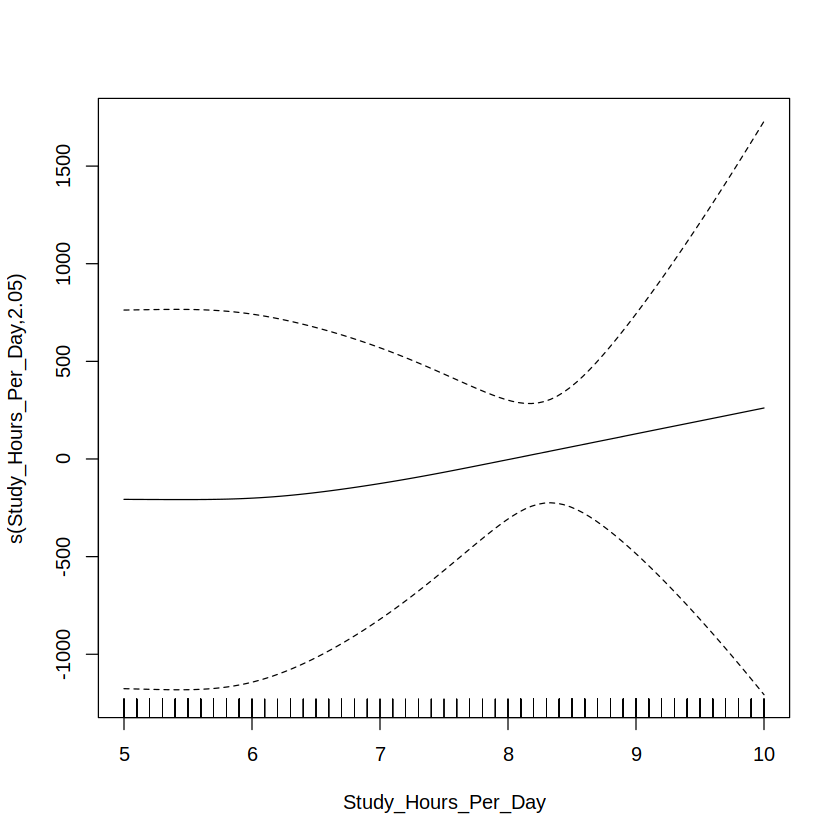

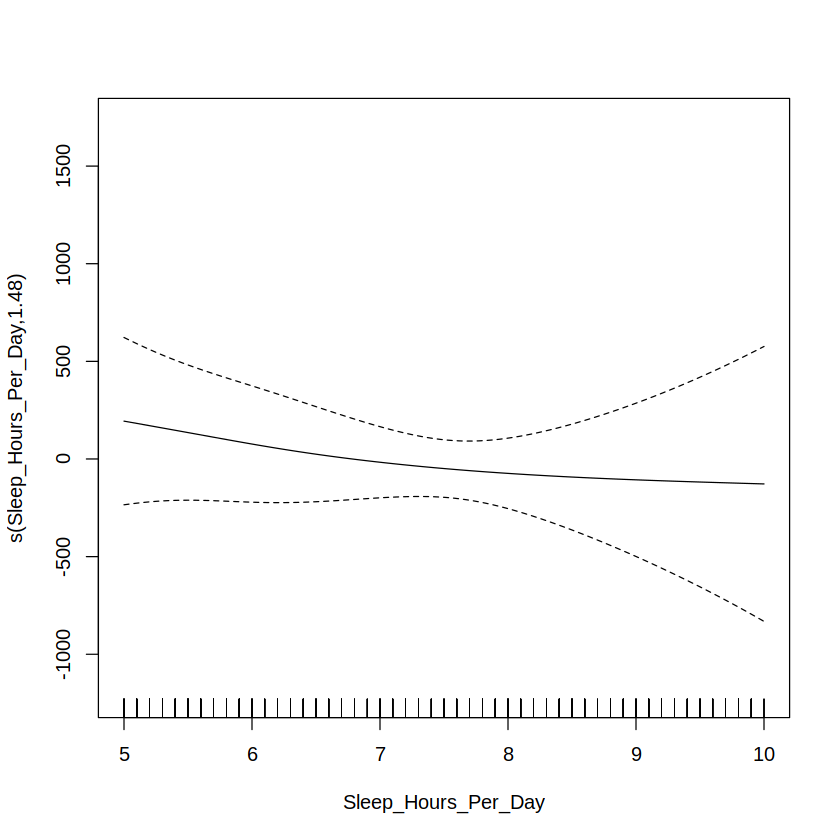

In [36]:
plot.gam(stress_gam1)

Both edf's are small around 1 and 2 and the graphs indicate that you could draw a straight line through the confidence intervals, so it's safe to conclude that the smoothing parameter is not necessary and the glm represents the data well. In other words, the features Study_Hours_Per_Day and Sleep_Hours_Per_Day can be approximated by a linear relationship. 

### Difference in Means Between Two Groups

Here, I just want a visual to look at the differences between two groups

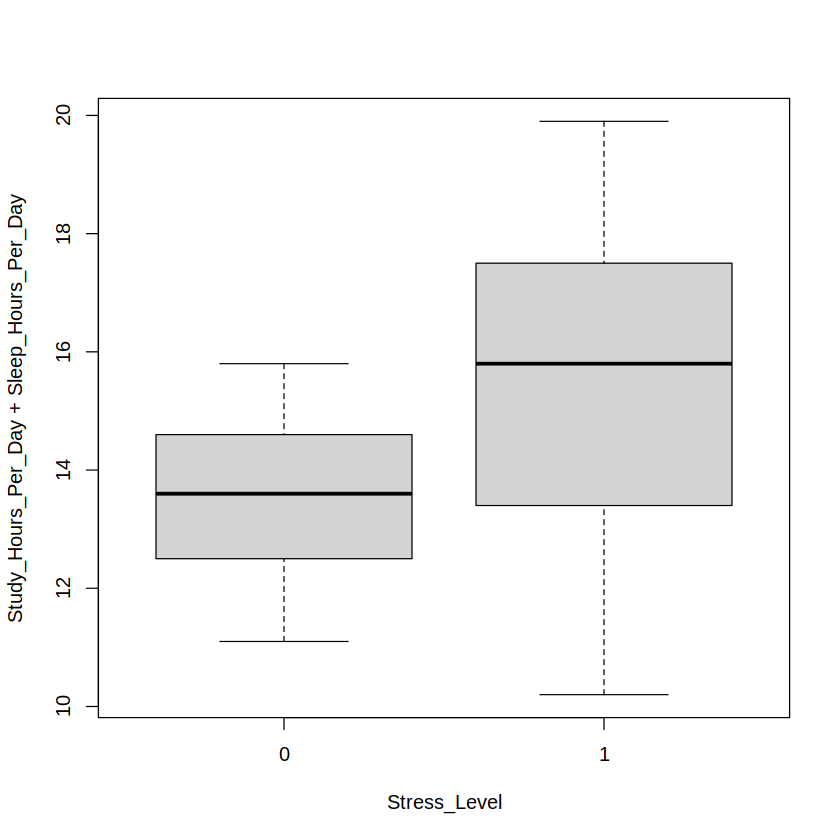

In [37]:
boxplot(Study_Hours_Per_Day + Sleep_Hours_Per_Day ~ Stress_Level, data=stress_df)

Although no official test is conducted here, I wanted to see the difference in means between the high and low stress groups. I proved that Stress_Level can be approximated by a linear relationship between Study_Hours_Per_Day and Sleep_Hours_Per_Day. It appears that the more an individual studies and sleeps per day, the more likely they are to belong to the high stress group. There is more of a spread in the high stress group, but the mean of the high stress is roughly at the same level as the top whisker for the low stress group. 

**Report**

With GPA as the response, I ran a regression model with all the features to make predictions on GPA and found that there was only one significant feature, Study_Hours_Per_Day. To interpret feature selection among different sized models, I used the regsubsets() command and printed the AIC, BIC, and adj R^2 values for each sized model. The AIC chose model two, the BIC chose model 1, and the adjusted R^2 chose model 4. Above, there is an explanation of when each measure is best.

I conducted F-tests for each chosen model against the full model, and each reduced model against one another and was presented with large p values, indicating that I fail to reject the null hypothesis, concluding that the reduced model is sufficient. Therefore, the smallest model, the BIC, which only has Study_Hours_Per_Day as a predictor, explains the data sufficiently as it is the most reduced model. I assumed that this may be the case after observing the AIC, BIC, and adjusted R^2 values initially because all the adjusted R^2 were very close to each other, within 0.02. I interpreted this to mean that there was minimal variability between the predicted and response values when additional features were added, so most likely, the model with one predictor would be sufficient. I used the bic model to make predictions using the testing set and found that the predicted values were very close to the actual values. Overall, the regression models indicated that the one-predictor model, Study_Hours_Per_Day, was sufficient in predicting the GPA. Although this result is not surprising, I would have thought the other features such as Sleep Hours or Extracurricular Hours would have been more relevant. 

Next, I wanted to model Stress_Level as the response using Generalized Linear Models (GLMs) and Generalized Additive Models (GAMs). First, I ran a GLM on all the predictors and found two that were significant: Study_Hours_Per_Day and Sleep_Hours_Per_Day. Using these two variables, I ran another GLM and found that both factors were still significant and this model had a lower AIC than the full GLM. Then, I conducted an ANOVA test between the full and reduced models and concluded that the reduced model was sufficient for prediction of Stress_Level using Study_Hours_Per_Day and Sleep_Hours_Per_Day as predictors. 

In case there were any nonlinear underlying patterns in my data, I ran a GAM on the reduced model I found using the GLM. In the GAM, Stress_Level was the response and Study_Hours_Per_Day and Sleep_Hours_Per_Day were predictors that used a smoothing function. In this model, neither feature was significant and each had small edf values around one and two. For further confirmation that the smoothing parameter was not necessary, I plotted the smoothed parameters. Since you could draw a straight line through the confidence interval curves, I concluded that the parameters Study_Hours_Per_Day and Sleep_Hours_Per_Day could be approximated with a linear relationship to predict Stress_Level. 